In [1]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider


In [2]:
# trades = [
#     {
#         'entry_time': '23/05/2025 14:06:34',
#         'exit_time': '23/05/2025 14:19:50',
#         'asset': 'MESM5',
#         'direction': 'Sell',
#         'entry_price': 5842.25,
#         'exit_price': 5832.0,
#         'position_size': 2,
#         'PnL': 102.5,
#         'profit_ticks': 41,
#         'account': 'DEMO26ZF9',
#         'exchange': 'CME_Ind',
#         'order_id_entry': 1248821956,
#         'order_id_exit': 1248822398
#     },
#     {
#         'entry_time': '23/05/2025 13:18:11',
#         'exit_time': '23/05/2025 13:29:15',
#         'asset': 'MESM5',
#         'direction': 'Sell',
#         'entry_price': 5832.5,
#         'exit_price': 5836.5,
#         'position_size': 2,
#         'PnL': -40.0,
#         'profit_ticks': -16,
#         'account': 'DEMO26ZF9',
#         'exchange': 'CME_Ind',
#         'order_id_entry': 1248616739,
#         'order_id_exit': 1248616766
#     }
# ]

In [3]:
# =======================================
# CONTROL opcional para forzar datos sintéticos
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================

hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    # Generación de datos sintéticos para probar rachas
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

trades_df

,entry_time,exit_time,asset,direction,entry_price,exit_price,position_size,PnL,profit_ticks,account,exchange,order_id_entry,order_id_exit
0,23/05/2025 13:10:00,23/05/2025 13:11:00,MESM5,Buy,5800,5801,1,75.64,30,DEMO,CME,1000000000,1000000001
1,23/05/2025 13:11:00,23/05/2025 13:12:00,MESM5,Buy,5801,5802,1,61.15,24,DEMO,CME,1000000002,1000000003
2,23/05/2025 13:12:00,23/05/2025 13:13:00,MESM5,Buy,5802,5803,1,116.80,46,DEMO,CME,1000000004,1000000005
3,23/05/2025 13:13:00,23/05/2025 13:14:00,MESM5,Buy,5803,5804,1,-54.77,-22,DEMO,CME,1000000006,1000000007
4,23/05/2025 13:14:00,23/05/2025 13:15:00,MESM5,Buy,5804,5805,1,-37.56,-16,DEMO,CME,1000000008,1000000009
5,23/05/2025 13:15:00,23/05/2025 13:16:00,MESM5,Buy,5805,5806,1,69.32,27,DEMO,CME,1000000010,1000000011
6,23/05/2025 13:16:00,23/05/2025 13:17:00,MESM5,Buy,5806,5807,1,70.59,28,DEMO,CME,1000000012,1000000013
7,23/05/2025 13:17:00,23/05/2025 13:18:00,MESM5,Buy,5807,5808,1,70.95,28,DEMO,CME,1000000014,1000000015
8,23/05/2025 13:18:00,23/05/2025 13:19:00,MESM5,Buy,5808,5809,1,88.75,35,DEMO,CME,1000000016,1000000017
9,23/05/2025 13:19:00,23/05/2025 13:20:00,MESM5,Buy,5809,5810,1,-40.71,-17,DEMO,CME,1000000018,1000000019


In [4]:
# =======================================
# Procesamiento de datos y cálculo de parámetros
# =======================================

def calcular_capital_actual(df, capital_inicial=360):
    return capital_inicial + df['PnL'].sum()

def build_bayesian_params(df, capital_inicial=360, max_drawdown=0.5, n_trades=100):
    wins = df[df['PnL'] > 0]['PnL']
    losses = df[df['PnL'] < 0]['PnL'].abs()
    return {
        'alpha': len(wins) + 1,
        'beta': len(losses) + 1,
        'win_shape': 1,
        'win_scale': wins.mean() if len(wins) > 0 else 1.0,
        'loss_shape': 1,
        'loss_scale': losses.mean() if len(losses) > 0 else 1.0,
        'initial_capital': calcular_capital_actual(df, capital_inicial),
        'max_drawdown': max_drawdown,
        'n_trades': n_trades
    }

params = build_bayesian_params(trades_df)
params

{'alpha': 10,
 'beta': 7,
 'win_shape': 1,
 'win_scale': np.float64(76.38333333333334),
 'loss_shape': 1,
 'loss_scale': np.float64(49.145),
 'initial_capital': np.float64(752.5800000000002),
 'max_drawdown': 0.5,
 'n_trades': 100}

In [5]:
# =======================================
# Simulación Monte Carlo Bayesiana
# =======================================

def bayesian_mc_simulation(initial_params, n_sims=10000):
    results = []
    for _ in range(n_sims):
        win_rate = beta.rvs(initial_params['alpha'], initial_params['beta'])
        avg_win = gamma.rvs(initial_params['win_shape'], scale=initial_params['win_scale'])
        avg_loss = gamma.rvs(initial_params['loss_shape'], scale=initial_params['loss_scale'])

        capital = initial_params['initial_capital']
        ruin_level = capital * (1 - initial_params['max_drawdown'])

        for _ in range(initial_params['n_trades']):
            if np.random.rand() < win_rate:
                capital += avg_win
            else:
                capital -= avg_loss
            if capital <= ruin_level:
                results.append(1)
                break
        else:
            results.append(0)
    return np.mean(results)

risk_of_ruin = bayesian_mc_simulation(params)
print("""
---
🔍 **Simulación Monte Carlo**
- Riesgo actualizado de ruina: {:.2f}%
---
""".format(risk_of_ruin * 100))


---
🔍 **Simulación Monte Carlo**
- Riesgo actualizado de ruina: 29.24%
---



In [6]:
# =======================================
# Probabilidad de rachas con enfoque científico (DP)
from functools import lru_cache

def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate

    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length:
            return 0.0
        if n == 0:
            return 1.0
        return (win_rate * prob_no_streak(n-1, 0) + 
                loss_rate * prob_no_streak(n-1, current_streak + 1))

    return 1 - prob_no_streak(num_trades, 0)

def analyze_streaks(win_rate, num_trades, max_streak=15):
    results = []
    for L in range(1, max_streak+1):
        prob = loss_streak_probability(win_rate, num_trades, L)
        results.append({
            'Streak Length': L,
            'Probability': prob,
            '1 in N Sequences': int(round(1/prob)) if prob > 0 else np.inf,
            'Expected Occurrences': (num_trades - L + 1) * ((1-win_rate)**L)
        })
    return pd.DataFrame(results)

def plot_streak_analysis(df):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df['Streak Length'], df['Probability'], 'b-o')
    plt.xlabel('Longitud de Rachas (L)')
    plt.ylabel('Probabilidad')
    plt.title('Prob. de al menos 1 racha de L pérdidas')

    plt.subplot(1, 2, 2)
    plt.plot(df['Streak Length'], df['Expected Occurrences'], 'r--o')
    plt.xlabel('Longitud de Rachas (L)')
    plt.ylabel('Ocurrencias Esperadas')
    plt.title('Número esperado de rachas')
    plt.tight_layout()
    plt.show()

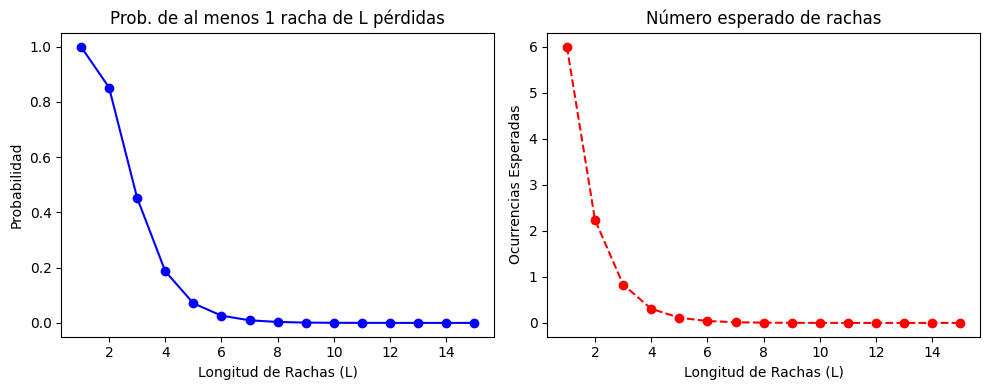


📊 **Estadísticas Generales**
- Expectancy: 26.17
- Profit Factor: 2.33
- Máximo Drawdown: -17.70%
- Máxima racha de ganancias: 4
- Máxima racha de pérdidas: 3

Profit Factor: 2.33
Máximo Drawdown: -17.70%
Máxima racha de ganancias: 4
Máxima racha de pérdidas: 3


In [7]:
# Ejecutar análisis con win_rate real
trades_df['win'] = trades_df['PnL'] > 0
emp_win_rate = trades_df['win'].mean()
streak_analysis_df = analyze_streaks(win_rate=emp_win_rate, num_trades=len(trades_df))
plot_streak_analysis(streak_analysis_df)
# =======================================

wins = trades_df[trades_df['PnL'] > 0]['PnL']
losses = trades_df[trades_df['PnL'] < 0]['PnL']

expectancy = trades_df['PnL'].mean()
profit_factor = wins.sum() / abs(losses.sum()) if not losses.empty else np.nan

trades_df['equity_curve'] = 360 + trades_df['PnL'].cumsum()
trades_df['peak'] = trades_df['equity_curve'].cummax()
trades_df['drawdown'] = trades_df['equity_curve'] - trades_df['peak']
trades_df['drawdown_pct'] = trades_df['drawdown'] / trades_df['peak']
max_drawdown = trades_df['drawdown_pct'].min()

# Rachas consecutivas de ganancias y pérdidas
trades_df['result'] = trades_df['PnL'].apply(lambda x: 'win' if x > 0 else 'loss')
trades_df['streak_id'] = (trades_df['result'] != trades_df['result'].shift()).cumsum()
streaks = trades_df.groupby(['streak_id', 'result']).size().reset_index(name='length')
max_win_streak = streaks[streaks['result'] == 'win']['length'].max() if 'win' in streaks['result'].values else 0
max_loss_streak = streaks[streaks['result'] == 'loss']['length'].max() if 'loss' in streaks['result'].values else 0

print("""
📊 **Estadísticas Generales**
- Expectancy: {:.2f}
- Profit Factor: {:.2f}
- Máximo Drawdown: {:.2f}%
- Máxima racha de ganancias: {}
- Máxima racha de pérdidas: {}
""".format(expectancy, profit_factor, max_drawdown * 100, max_win_streak, max_loss_streak))
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Máximo Drawdown: {max_drawdown*100:.2f}%")
print(f"Máxima racha de ganancias: {max_win_streak}")
print(f"Máxima racha de pérdidas: {max_loss_streak}")

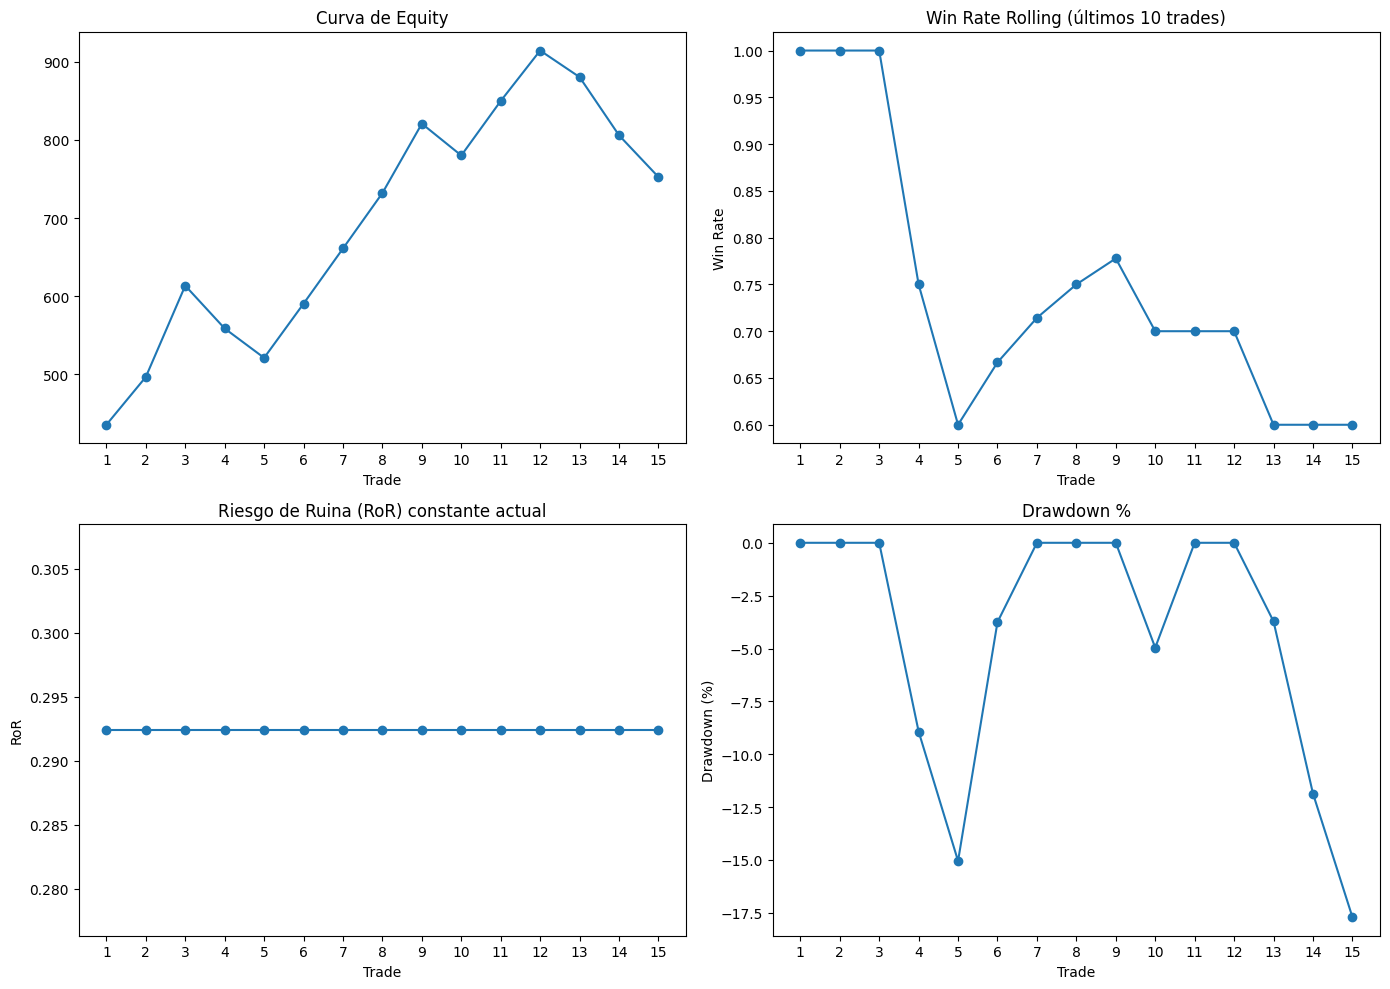

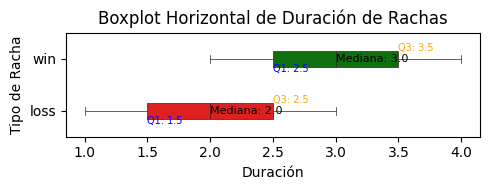


📈 **Promedios de Rachas**
- Duración promedio de rachas ganadoras: 3.00
- Duración promedio de rachas perdedoras: 2.00

Duración promedio de rachas perdedoras: 2.00


In [8]:
# =======================================
log_scale = False  # prevención de error si aún no está definido

# Visualizaciones del rendimiento
# =======================================

trades_df['trade_n'] = range(1, len(trades_df)+1)
trades_df['cumulative_PnL'] = trades_df['PnL'].cumsum()
trades_df['equity'] = 360 + trades_df['cumulative_PnL']
trades_df['win'] = trades_df['PnL'] > 0
trades_df['rolling_win_rate'] = trades_df['win'].rolling(10, min_periods=1).mean()
trades_df['RoR'] = risk_of_ruin

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(trades_df['trade_n'], trades_df['equity'], marker='o')
plt.xticks(trades_df['trade_n'])
plt.xticks(trades_df['trade_n'])
plt.title("Curva de Equity")
plt.xlabel("Trade")
if log_scale:
        plt.yscale('log')
        plt.ylabel("Equity")

plt.subplot(2, 2, 2)
plt.plot(trades_df['trade_n'], trades_df['rolling_win_rate'], marker='o')
plt.xticks(trades_df['trade_n'])
plt.xticks(trades_df['trade_n'])
plt.title("Win Rate Rolling (últimos 10 trades)")
plt.xlabel("Trade")
plt.ylabel("Win Rate")

plt.subplot(2, 2, 3)
plt.plot(trades_df['trade_n'], trades_df['RoR'], marker='o')
plt.xticks(trades_df['trade_n'])
plt.xticks(trades_df['trade_n'])
plt.title("Riesgo de Ruina (RoR) constante actual")
plt.xlabel("Trade")
plt.ylabel("RoR")

plt.subplot(2, 2, 4)
plt.plot(trades_df['trade_n'], trades_df['drawdown_pct'] * 100, marker='o')
plt.xticks(trades_df['trade_n'])
plt.xticks(trades_df['trade_n'])
plt.title("Drawdown %")
plt.xlabel("Trade")
plt.ylabel("Drawdown (%)")

plt.tight_layout()
plt.show()

# Gráfico de rachas consecutivas como boxplot horizontal
fig, ax = plt.subplots(figsize=(5, 2))
sns.boxplot(data=streaks, y='result', x='length', hue='result', dodge=False,
            palette={"win": "green", "loss": "red"}, linewidth=0.5, width=0.3, legend=False)
ax.set_title("Boxplot Horizontal de Duración de Rachas")
ax.set_xlabel("Duración")
ax.set_ylabel("Tipo de Racha")


# Añadir etiquetas con mediana y cuartiles
for result_type in ['win', 'loss']:
    data = streaks[streaks['result'] == result_type]['length']
    median = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    ypos = 0 if result_type == 'win' else 1
    ax.text(median, ypos, f"Mediana: {median:.1f}", va='center', ha='left', fontsize=8, color='black')
    ax.text(q1, ypos + 0.2, f"Q1: {q1:.1f}", va='center', ha='left', fontsize=7, color='blue')
    ax.text(q3, ypos - 0.2, f"Q3: {q3:.1f}", va='center', ha='left', fontsize=7, color='orange')

plt.tight_layout()
plt.show()

# Promedio de duración de rachas
avg_win_streak = streaks[streaks['result'] == 'win']['length'].mean() if 'win' in streaks['result'].values else 0
avg_loss_streak = streaks[streaks['result'] == 'loss']['length'].mean() if 'loss' in streaks['result'].values else 0
print("""
📈 **Promedios de Rachas**
- Duración promedio de rachas ganadoras: {:.2f}
- Duración promedio de rachas perdedoras: {:.2f}
""".format(avg_win_streak, avg_loss_streak))
print(f"Duración promedio de rachas perdedoras: {avg_loss_streak:.2f}")


In [ ]:
# =======================================
# Simulación de múltiples curvas de equity con sliders interactivos
# =======================================
from ipywidgets import interact, FloatSlider, IntSlider, Checkbox

def simulate_equity_curves(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity=3000):
    curves = []
    for _ in range(n_lines):
        equity = initial_equity
        path = [equity]
        for _ in range(n_trades):
            fluct = np.random.normal(1.0, 0.03)
            if np.random.rand() < win_rate / 100:
                equity += equity * (risk_per_trade / 100) * win_loss_ratio * fluct
            else:
                equity -= equity * (risk_per_trade / 100) * fluct
            path.append(equity)
        curves.append(path)
    return curves

def plot_equity_simulation(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity_offset=0, log_scale=False):
    capital_actual = calcular_capital_actual(trades_df) + initial_equity_offset
    curves = simulate_equity_curves(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity=capital_actual)
    plt.figure(figsize=(10, 5))
    for path in curves:
        plt.plot(path, alpha=0.4, linewidth=1)
    avg_path = np.mean(curves, axis=0)
    plt.plot(avg_path, color='black', linewidth=2.5, label="Media", zorder=10)
    plt.title(f"Simulación de Curvas de Equity (Start: ${capital_actual:,.0f})")
    plt.xlabel("# Trade")
    plt.ylabel("Equity")
    if log_scale:
        plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

interact(
    plot_equity_simulation,
    win_rate=FloatSlider(value=50, min=0, max=100, step=1, description='Win %'),
    win_loss_ratio=IntSlider(value=2, min=0.5, max=10, step=0.1, description='Win/Loss R'),
    risk_per_trade=FloatSlider(value=10, min=0, max=20, step=0.5, description='Risk %'),
    n_trades=IntSlider(value=32, min=10, max=2000, step=10, description='# Trades'),
    n_lines=IntSlider(value=10, min=1, max=200, step=1, description='Paths'),
    initial_equity_offset=IntSlider(value=0, min=0, max=5000, step=100, description='Start Adj.'),
    log_scale=Checkbox(value=False, description='Log Scale')
)


interactive(children=(FloatSlider(value=50.0, description='Win %', step=1.0), IntSlider(value=2, description='…

<function __main__.plot_equity_simulation(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity_offset=0, log_scale=False)>

In [10]:
# =======================================
# Exportar a Excel Diario
# =======================================

fecha = datetime.now().strftime("%Y%m%d")
excel_name = f"dashboard_trading_{fecha}.xlsx"

with pd.ExcelWriter(excel_name) as writer:
    trades_df.to_excel(writer, sheet_name="Trades", index=False)
    pd.DataFrame([params]).to_excel(writer, sheet_name="Parametros", index=False)
    pd.DataFrame({
        "risk_of_ruin": [risk_of_ruin],
        "avg_win_streak": [avg_win_streak],
        "avg_loss_streak": [avg_loss_streak],
        "expectancy": [expectancy],
        "profit_factor": [profit_factor],
        "max_drawdown_pct": [max_drawdown],
        "max_win_streak": [max_win_streak],
        "max_loss_streak": [max_loss_streak]
    }).to_excel(writer, sheet_name="Metricas", index=False)

print(f"\nExportado a Excel: {excel_name}")


Exportado a Excel: dashboard_trading_20250526.xlsx


In [11]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# =======================================
# CONTROL opcional para forzar datos sintéticos
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================

hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    # Generación de datos sintéticos para probar rachas
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

# =======================================
# Procesamiento de datos y cálculo de parámetros
# =======================================

def calcular_capital_actual(df, capital_inicial=360):
    return capital_inicial + df['PnL'].sum()

def build_bayesian_params(df, capital_inicial=360, max_drawdown=0.5, n_trades=100):
    wins = df[df['PnL'] > 0]['PnL']
    losses = df[df['PnL'] < 0]['PnL'].abs()
    return {
        'alpha': len(wins) + 1,
        'beta': len(losses) + 1,
        'win_shape': 1,
        'win_scale': wins.mean() if len(wins) > 0 else 1.0,
        'loss_shape': 1,
        'loss_scale': losses.mean() if len(losses) > 0 else 1.0,
        'initial_capital': calcular_capital_actual(df, capital_inicial),
        'max_drawdown': max_drawdown,
        'n_trades': n_trades
    }

params = build_bayesian_params(trades_df)

# =======================================
# Simulación de múltiples curvas de equity con sliders interactivos
# =======================================
from ipywidgets import interact, FloatSlider, IntSlider, Checkbox

def simulate_equity_curves(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity=3000):
    curves = []
    for _ in range(n_lines):
        equity = initial_equity
        path = [equity]
        for _ in range(n_trades):
            fluct = np.random.normal(1.0, 0.03)
            if np.random.rand() < win_rate / 100:
                equity += equity * (risk_per_trade / 100) * win_loss_ratio * fluct
            else:
                equity -= equity * (risk_per_trade / 100) * fluct
            path.append(equity)
        curves.append(path)
    return curves

def plot_equity_simulation(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity_offset=0, log_scale=False):
    capital_actual = calcular_capital_actual(trades_df) + initial_equity_offset
    curves = simulate_equity_curves(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity=capital_actual)
    plt.figure(figsize=(10, 5))
    for path in curves:
        plt.plot(path, alpha=0.4, linewidth=1)
    avg_path = np.mean(curves, axis=0)
    plt.plot(avg_path, color='black', linewidth=2.5, label="Media", zorder=10)
    plt.title(f"Simulación de Curvas de Equity (Start: ${capital_actual:,.0f})")
    plt.xlabel("# Trade")
    plt.ylabel("Equity")
    if log_scale:
        plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

interact(
    plot_equity_simulation,
    win_rate=FloatSlider(value=55, min=0, max=100, step=1, description='Win %'),
    win_loss_ratio=IntSlider(value=2, min=1, max=10, step=1, description='Win/Loss R'),
    risk_per_trade=FloatSlider(value=1, min=0, max=50, step=0.5, description='Risk %'),
    n_trades=IntSlider(value=100, min=10, max=200, step=10, description='# Trades'),
    n_lines=IntSlider(value=5, min=1, max=20, step=1, description='Paths'),
    initial_equity_offset=IntSlider(value=0, min=0, max=5000, step=100, description='Start Adj.'),
    log_scale=Checkbox(value=False, description='Log Scale')
)


# =======================================
# Exportar a Excel Diario
# =======================================

fecha = datetime.now().strftime("%Y%m%d")
excel_name = f"dashboard_trading_{fecha}.xlsx"

with pd.ExcelWriter(excel_name) as writer:
    trades_df.to_excel(writer, sheet_name="Trades", index=False)
    pd.DataFrame([params]).to_excel(writer, sheet_name="Parametros", index=False)
    pd.DataFrame({
        "risk_of_ruin": [risk_of_ruin],
        "avg_win_streak": [avg_win_streak],
        "avg_loss_streak": [avg_loss_streak],
        "expectancy": [expectancy],
        "profit_factor": [profit_factor],
        "max_drawdown_pct": [max_drawdown],
        "max_win_streak": [max_win_streak],
        "max_loss_streak": [max_loss_streak]
    }).to_excel(writer, sheet_name="Metricas", index=False)

print(f"\nExportado a Excel: {excel_name}")


interactive(children=(FloatSlider(value=55.0, description='Win %', step=1.0), IntSlider(value=2, description='…


Exportado a Excel: dashboard_trading_20250526.xlsx


In [12]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider

# =======================================
# Función de cálculo de probabilidad de racha
# =======================================

@lru_cache(maxsize=None)
def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate

    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length:
            return 0.0
        if n == 0:
            return 1.0
        return (win_rate * prob_no_streak(n-1, 0) + 
                loss_rate * prob_no_streak(n-1, current_streak + 1))

    return 1 - prob_no_streak(num_trades, 0)

# =======================================
# Tabla de probabilidades de rachas según win rate y longitud (DINÁMICA)
# =======================================

def generate_streak_probability_table(trades=50, max_streak=11):
    percentages = list(range(5, 100, 5))
    table = []
    for win_rate in percentages:
        row = {'Win %': win_rate}
        for L in range(2, max_streak + 1):
            prob = loss_streak_probability(win_rate / 100, trades, L)
            row[f'≥{L}'] = f"{prob*100:.1f}%"
        table.append(row)
    return pd.DataFrame(table)

def plot_streak_probability_table(trades=50, max_streak=11):
    df = generate_streak_probability_table(trades=trades, max_streak=max_streak)
    df_numeric = df.set_index('Win %').apply(lambda col: col.str.rstrip('%').astype(float))
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(
        df_numeric,
        cmap='RdYlGn_r', annot=df.set_index('Win %'), fmt='',
        cbar=False, linewidths=0.5, ax=ax
    )
    ax.set_title(f'Probabilidad de ver al menos (X) pérdidas consecutivas en {trades} trades')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=9, ha='right')
    plt.tight_layout()
    plt.show()

interact(
    plot_streak_probability_table,
    trades=IntSlider(value=50, min=10, max=200, step=10, description='# Trades'),
    max_streak=IntSlider(value=11, min=2, max=20, step=1, description='Racha ≥')
)



interactive(children=(IntSlider(value=50, description='# Trades', max=200, min=10, step=10), IntSlider(value=1…

<function __main__.plot_streak_probability_table(trades=50, max_streak=11)>

### 📈 Cálculo de Kelly (Basado en Datos Reales)

Se ha integrado un cálculo riguroso y matemáticamente sólido del **Criterio de Kelly** en el notebook, utilizando directamente los datos del historial de operaciones (`trades_df`).

---

#### 🔬 Cambios clave implementados:

- **Cálculo automático del Kelly**:
  - `P` (Win rate) = proporción de operaciones ganadoras
  - `R` (Win/Loss ratio) = media de ganancias / media de pérdidas
- **Fórmula empleada**:
  \[
  \text{Kelly} = P - \frac{(1 - P)}{R}
  \]
- **Resultados mostrados en porcentaje** de capital óptimo a arriesgar.

---

#### 📋 Ejemplo de salida
```
📈 Cálculo de Kelly (Método Tradicional)

Win rate (P): 42.86%

Win/Loss ratio (R): 2.10

Kelly % óptimo teórico: 9.52%
```


---

#### ✅ Ventajas del enfoque:

- Utiliza tus **datos reales** de rendimiento.
- Elimina supuestos erróneos como la equiprobabilidad.
- Se actualiza de forma **dinámica** conforme ingresan nuevos trades.

---

¿Y ahora qué?

- Puedes añadir una **versión fraccional de Kelly** (ej. ½ Kelly) para ser más conservador.
- También es posible integrar la **versión alternativa** basada en porcentajes de ganancia/pérdida sobre capital (`G` y `V`).

¿Quieres que se añada alguna de estas variantes ahora?


In [13]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider, FloatSlider

# =======================================
# CONTROL opcional para forzar datos sintéticos
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================

hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

# =======================================
# Función de cálculo de probabilidad de racha
# =======================================

@lru_cache(maxsize=None)
def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate

    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length:
            return 0.0
        if n == 0:
            return 1.0
        return (win_rate * prob_no_streak(n-1, 0) + 
                loss_rate * prob_no_streak(n-1, current_streak + 1))

    return 1 - prob_no_streak(num_trades, 0)

# =======================================
# Cálculo de Kelly mejorado con sliders para ajuste visual
# =======================================

def calcular_kelly(P, R):
    return P - (1 - P) / R if R != 0 else 0

def visualizar_kelly(win_rate_slider, ratio_slider):
    P = win_rate_slider / 100
    R = ratio_slider
    kelly = calcular_kelly(P, R)
    print("""
    📊 **Simulación Interactiva de Kelly**
    - Win rate (P): {:.2f}%
    - Win/Loss ratio (R): {:.2f}
    - Kelly % sugerido: {:.2f}%
    """.format(win_rate_slider, R, kelly * 100))

interact(
    visualizar_kelly,
    win_rate_slider=FloatSlider(value=50, min=10, max=100, step=0.5, description='Win %'),
    ratio_slider=FloatSlider(value=2.0, min=0.5, max=10.0, step=0.1, description='Win/Loss R')
)

# =======================================
# Tabla de probabilidades de rachas según win rate y longitud (DINÁMICA)
# =======================================

def generate_streak_probability_table(trades=50, max_streak=11):
    percentages = list(range(5, 100, 5))
    table = []
    for win_rate in percentages:
        row = {'Win %': win_rate}
        for L in range(2, max_streak + 1):
            prob = loss_streak_probability(win_rate / 100, trades, L)
            row[f'≥{L}'] = f"{prob*100:.1f}%"
        table.append(row)
    return pd.DataFrame(table)

def plot_streak_probability_table(trades=50, max_streak=11):
    df = generate_streak_probability_table(trades=trades, max_streak=max_streak)
    df_numeric = df.set_index('Win %').apply(lambda col: col.str.rstrip('%').astype(float))
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(
        df_numeric,
        cmap='RdYlGn_r', annot=df.set_index('Win %'), fmt='',
        cbar=False, linewidths=0.5, ax=ax
    )
    ax.set_title(f'Probabilidad de ver al menos (X) pérdidas consecutivas en {trades} trades')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=9, ha='right')
    plt.tight_layout()
    plt.show()

interact(
    plot_streak_probability_table,
    trades=IntSlider(value=50, min=10, max=200, step=10, description='# Trades'),
    max_streak=IntSlider(value=11, min=2, max=20, step=1, description='Racha ≥')
)



interactive(children=(FloatSlider(value=50.0, description='Win %', min=10.0, step=0.5), FloatSlider(value=2.0,…

interactive(children=(IntSlider(value=50, description='# Trades', max=200, min=10, step=10), IntSlider(value=1…

<function __main__.plot_streak_probability_table(trades=50, max_streak=11)>

In [14]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider, FloatSlider

# =======================================
# CONTROL opcional para forzar datos sintéticos
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================

hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

# =======================================
# Función de cálculo de probabilidad de racha
# =======================================

@lru_cache(maxsize=None)
def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate

    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length:
            return 0.0
        if n == 0:
            return 1.0
        return (win_rate * prob_no_streak(n-1, 0) + 
                loss_rate * prob_no_streak(n-1, current_streak + 1))

    return 1 - prob_no_streak(num_trades, 0)

# =======================================
# Kelly mejorado con penalización por drawdown estimado
# =======================================

def calcular_kelly(P, R):
    if R == 0: return 0
    return P - (1 - P) / R

def penalizar_kelly(kelly, streak_prob):
    return max(0, kelly / (1 + streak_prob))

def simulador_kelly(win_rate_slider, ratio_slider, trades_slider, racha_slider):
    P = win_rate_slider / 100
    R = ratio_slider
    kelly_raw = calcular_kelly(P, R)
    prob_racha = loss_streak_probability(P, trades_slider, racha_slider)
    kelly_ajustado = penalizar_kelly(kelly_raw, prob_racha)

    print("""
    📈 **Simulación Interactiva de Kelly Mejorado**
    - Win rate (P): {:.2f}%
    - Win/Loss ratio (R): {:.2f}
    - Trades: {}
    - Racha evaluada: ≥{}
    - Probabilidad de sufrir racha: {:.2f}%
    - Kelly % clásico: {:.2f}%
    - Kelly % ajustado (con penalización): {:.2f}%
    """.format(
        win_rate_slider, R, trades_slider, racha_slider,
        prob_racha * 100, kelly_raw * 100, kelly_ajustado * 100
    ))

interact(
    simulador_kelly,
    win_rate_slider=FloatSlider(value=50, min=10, max=100, step=1, description='Win %'),
    ratio_slider=FloatSlider(value=2.0, min=0.5, max=10.0, step=0.1, description='Win/Loss R'),
    trades_slider=IntSlider(value=100, min=10, max=200, step=10, description='# Trades'),
    racha_slider=IntSlider(value=5, min=2, max=20, step=1, description='Racha ≥')
)

# =======================================
# Tabla de probabilidades de rachas según win rate y longitud (DINÁMICA)
# =======================================

def generate_streak_probability_table(trades=50, max_streak=11):
    percentages = list(range(5, 100, 5))
    table = []
    for win_rate in percentages:
        row = {'Win %': win_rate}
        for L in range(2, max_streak + 1):
            prob = loss_streak_probability(win_rate / 100, trades, L)
            row[f'≥{L}'] = f"{prob*100:.1f}%"
        table.append(row)
    return pd.DataFrame(table)

def plot_streak_probability_table(trades=50, max_streak=11):
    df = generate_streak_probability_table(trades=trades, max_streak=max_streak)
    df_numeric = df.set_index('Win %').apply(lambda col: col.str.rstrip('%').astype(float))
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(
        df_numeric,
        cmap='RdYlGn_r', annot=df.set_index('Win %'), fmt='',
        cbar=False, linewidths=0.5, ax=ax
    )
    ax.set_title(f'Probabilidad de ver al menos (X) pérdidas consecutivas en {trades} trades')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=9, ha='right')
    plt.tight_layout()
    plt.show()

interact(
    plot_streak_probability_table,
    trades=IntSlider(value=50, min=10, max=200, step=10, description='# Trades'),
    max_streak=IntSlider(value=11, min=2, max=20, step=1, description='Racha ≥')
)

interactive(children=(FloatSlider(value=50.0, description='Win %', min=10.0, step=1.0), FloatSlider(value=2.0,…

interactive(children=(IntSlider(value=50, description='# Trades', max=200, min=10, step=10), IntSlider(value=1…

<function __main__.plot_streak_probability_table(trades=50, max_streak=11)>

In [15]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Output, VBox
import matplotlib.ticker as mticker

# =======================================
# CONTROL opcional para forzar datos sintéticos
# =======================================
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================
hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

# =======================================
# Kelly mejorado con visualización interactiva
# =======================================
def calcular_kelly(P, R):
    if R == 0:
        return 0
    return max(P - (1 - P) / R, 0)

def calcular_ruina(capital_inicial, riesgo_pct, max_drawdown):
    capital = capital_inicial
    riesgo = riesgo_pct / 100
    n = 0
    capitales = [capital]
    while capital > capital_inicial * (1 - max_drawdown):
        capital *= (1 - riesgo)
        capitales.append(capital)
        n += 1
        if n > 100:  # Limita las simulaciones para evitar cuelgues
            break
    return n, capitales

def simulador_kelly_dinamico(P, R, capital_inicial=1000, max_drawdown=0.9, log_scale=False):
    kelly = calcular_kelly(P, R)
    riesgo_k = kelly
    riesgo_50 = kelly * 0.5
    riesgo_25 = kelly * 0.25

    ruina_k, cap_k = calcular_ruina(capital_inicial, riesgo_k * 100, max_drawdown)
    ruina_50, cap_50 = calcular_ruina(capital_inicial, riesgo_50 * 100, max_drawdown)
    ruina_25, cap_25 = calcular_ruina(capital_inicial, riesgo_25 * 100, max_drawdown)

    output = Output()
    with output:
        print(f"\n📈 Simulación Interactiva de Kelly Mejorado")
        print(f"- Win rate (P): {P*100:.2f}%")
        print(f"- Win/Loss ratio (R): {R:.2f}")
        print(f"- Capital inicial: ${capital_inicial:,.0f}")
        print(f"- Kelly % clásico: {kelly*100:.2f}%")
        print(f"- Racha para ruina (<{int(max_drawdown*100)}%):")
        print(f"    · 100% Kelly: {ruina_k} trades")
        print(f"    · 50% Kelly: {ruina_50} trades")
        print(f"    · 25% Kelly: {ruina_25} trades")
    display(output)

    plt.figure(figsize=(10, 6))
    plt.plot(cap_k, label=f"100% Kelly ({ruina_k} trades)", linewidth=2)
    plt.plot(cap_50, label=f"50% Kelly ({ruina_50} trades)", linewidth=2)
    plt.plot(cap_25, label=f"25% Kelly ({ruina_25} trades)", linewidth=2)

    plt.axhline(y=capital_inicial * (1 - max_drawdown), color='red', linestyle='--', label='Límite ruina')
    plt.title("Simulación de Ruina según % Kelly")
    plt.xlabel("# Trades perdedores consecutivos")
    plt.ylabel("Capital restante")
    if log_scale:
        plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

interact(
    simulador_kelly_dinamico,
    P=FloatSlider(value=0.5, min=0.1, max=0.9, step=0.01, description='Win %'),
    R=FloatSlider(value=2.0, min=0.5, max=10.0, step=0.1, description='Win/Loss R'),
    capital_inicial=IntSlider(value=1000, min=100, max=10000, step=100, description='Capital $'),
    max_drawdown=FloatSlider(value=0.9, min=0.1, max=0.9, step=0.05, description='Drawdown %'),
    log_scale=Checkbox(value=False, description='Log scale')
)


interactive(children=(FloatSlider(value=0.5, description='Win %', max=0.9, min=0.1, step=0.01), FloatSlider(va…

<function __main__.simulador_kelly_dinamico(P, R, capital_inicial=1000, max_drawdown=0.9, log_scale=False)>

In [16]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown, Output, VBox
import matplotlib.ticker as mticker

# =======================================
# CONTROL opcional para forzar datos sintéticos
# =======================================
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================
hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

# =======================================
# Kelly mejorado con visualización interactiva y simulación aleatoria
# =======================================
def calcular_kelly(P, R):
    if R == 0:
        return 0
    return max(P - (1 - P) / R, 0)

def calcular_ruina(capital_inicial, riesgo_pct, max_drawdown):
    capital = capital_inicial
    riesgo = riesgo_pct / 100
    n = 0
    capitales = [capital]
    while capital > capital_inicial * (1 - max_drawdown):
        capital *= (1 - riesgo)
        capitales.append(capital)
        n += 1
        if n > 100:
            break
    return n, capitales

def simular_random(P, R, riesgo_pct, n_trades, capital_inicial):
    capital = capital_inicial
    capitales = [capital]
    riesgo = riesgo_pct / 100
    for _ in range(n_trades):
        if np.random.rand() < P:
            capital += capital * riesgo * R
        else:
            capital -= capital * riesgo
        capitales.append(capital)
    return capitales

def simulador_kelly_dinamico(P, R, capital_inicial=1000, max_drawdown=0.9, log_scale=False, simulacion='Determinista'):
    kelly = calcular_kelly(P, R)

    output = Output()
    with output:
        print(f"\n📈 Simulación Interactiva de Kelly Mejorado")
        print(f"- Win rate (P): {P*100:.2f}%")
        print(f"- Win/Loss ratio (R): {R:.2f}")
        print(f"- Capital inicial: ${capital_inicial:,.0f}")
        print(f"- Kelly % dinámico: {kelly*100:.2f}%")

    display(output)

    plt.figure(figsize=(10, 6))

    if simulacion == 'Determinista':
        for fraccion, label in zip([1.0, 0.5, 0.25], ["100% Kelly", "50% Kelly", "25% Kelly"]):
            r, caps = calcular_ruina(capital_inicial, kelly * fraccion * 100, max_drawdown)
            plt.plot(caps, label=f"{label} ({r} trades)", linewidth=2)
    else:
        for fraccion, label in zip([1.0, 0.5, 0.25], ["100% Kelly", "50% Kelly", "25% Kelly"]):
            caps = simular_random(P, R, kelly * fraccion * 100, 100, capital_inicial)
            plt.plot(caps, label=f"{label}", linewidth=2)

    plt.axhline(y=capital_inicial * (1 - max_drawdown), color='red', linestyle='--', label='Límite ruina')
    plt.title("Simulación de Ruina según % Kelly")
    plt.xlabel("# Trades")
    plt.ylabel("Capital restante")
    if log_scale:
        plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

interact(
    simulador_kelly_dinamico,
    P=FloatSlider(value=0.5, min=0.1, max=0.9, step=0.01, description='Win %'),
    R=FloatSlider(value=2.0, min=0.5, max=10.0, step=0.1, description='Win/Loss R'),
    capital_inicial=IntSlider(value=1000, min=100, max=10000, step=100, description='Capital $'),
    max_drawdown=FloatSlider(value=0.6, min=0.1, max=0.9, step=0.05, description='Drawdown %'),
    log_scale=Checkbox(value=False, description='Log scale'),
    simulacion=Dropdown(options=['Determinista', 'Estocástica'], value='Determinista', description='Modo')
)


interactive(children=(FloatSlider(value=0.5, description='Win %', max=0.9, min=0.1, step=0.01), FloatSlider(va…

<function __main__.simulador_kelly_dinamico(P, R, capital_inicial=1000, max_drawdown=0.9, log_scale=False, simulacion='Determinista')>

In [17]:
# 01_sin_historial.ipynb - Modelo Científico de Trading sin Historial (Actualizado Dinámicamente)

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import lru_cache
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown, Output, VBox
import matplotlib.ticker as mticker

# =======================================
# CONTROL opcional para forzar datos sintéticos
# =======================================
FORZAR_DATOS_SINTETICOS = False
if FORZAR_DATOS_SINTETICOS and os.path.exists("trades_hist.csv"):
    os.remove("trades_hist.csv")

# =======================================
# Cargar historial y nuevos trades
# =======================================
hist_path = "trades_hist.csv"
nuevos_path = "nuevos_trades.csv"

if os.path.exists(hist_path):
    trades_df = pd.read_csv(hist_path)
    generar_datos_sinteticos = trades_df.empty
else:
    generar_datos_sinteticos = True

if generar_datos_sinteticos:
    trades = []
    resultados = ['win'] * 3 + ['loss'] * 2 + ['win'] * 4 + ['loss'] * 1 + ['win'] * 2 + ['loss'] * 3
    for i, res in enumerate(resultados):
        pnl = np.random.uniform(50, 150) if res == 'win' else -np.random.uniform(30, 80)
        trades.append({
            'entry_time': f'23/05/2025 13:{10+i}:00',
            'exit_time': f'23/05/2025 13:{11+i}:00',
            'asset': 'MESM5',
            'direction': 'Buy',
            'entry_price': 5800 + i,
            'exit_price': 5800 + i + 1,
            'position_size': 1,
            'PnL': round(pnl, 2),
            'profit_ticks': int(pnl // 2.5),
            'account': 'DEMO',
            'exchange': 'CME',
            'order_id_entry': 1000000000 + i*2,
            'order_id_exit': 1000000000 + i*2 + 1
        })
    trades_df = pd.DataFrame(trades)
    trades_df.to_csv(hist_path, index=False)

if os.path.exists(nuevos_path):
    nuevos_df = pd.read_csv(nuevos_path)
    trades_df = pd.concat([trades_df, nuevos_df], ignore_index=True).drop_duplicates(subset=['order_id_entry', 'order_id_exit'])
    trades_df.to_csv(hist_path, index=False)

if trades_df.empty:
    raise ValueError("No hay datos disponibles para procesar.")

# =======================================
# Kelly mejorado con visualización interactiva y simulación aleatoria
# =======================================
def calcular_kelly(P, R):
    if R == 0:
        return 0
    return max(P - (1 - P) / R, 0)

def calcular_ruina(capital_inicial, riesgo_pct, max_drawdown):
    capital = capital_inicial
    riesgo = riesgo_pct / 100
    n = 0
    capitales = [capital]
    while capital > capital_inicial * (1 - max_drawdown):
        capital *= (1 - riesgo)
        capitales.append(capital)
        n += 1
        if n > 100:
            break
    return n, capitales

def simular_random(P, R, riesgo_pct, n_trades, capital_inicial):
    capital = capital_inicial
    capitales = [capital]
    riesgo = riesgo_pct / 100
    for _ in range(n_trades):
        if np.random.rand() < P:
            capital += capital * riesgo * R
        else:
            capital -= capital * riesgo
        capitales.append(capital)
    return capitales

def simulador_kelly_dinamico(P, R, kelly_fraccion=1.0, capital_inicial=1000, max_drawdown=0.9, log_scale=False, simulacion='Determinista'):
    kelly = calcular_kelly(P, R)
    fracciones = [kelly_fraccion, kelly_fraccion * 0.5, kelly_fraccion * 0.25]
    labels = [f"{kelly_fraccion*100:.0f}% Kelly", f"{kelly_fraccion*50:.0f}% Kelly", f"{kelly_fraccion*25:.0f}% Kelly"]

    output = Output()
    with output:
        print(f"\n📈 Simulación Interactiva de Kelly Mejorado")
        print(f"- Win rate (P): {P*100:.2f}%")
        print(f"- Win/Loss ratio (R): {R:.2f}")
        print(f"- Capital inicial: ${capital_inicial:,.0f}")
        print(f"- Kelly % dinámico base: {kelly*100:.2f}%")
        print(f"- Kelly % aplicado (slider): {kelly*kelly_fraccion*100:.2f}%")

    display(output)

    plt.figure(figsize=(10, 6))

    for fraccion, label in zip(fracciones, labels):
        if simulacion == 'Determinista':
            r, caps = calcular_ruina(capital_inicial, kelly * fraccion * 100, max_drawdown)
            plt.plot(caps, label=f"{label} ({r} trades)", linewidth=2)
        else:
            caps = simular_random(P, R, kelly * fraccion * 100, 100, capital_inicial)
            plt.plot(caps, label=label, linewidth=2)

    plt.axhline(y=capital_inicial * (1 - max_drawdown), color='red', linestyle='--', label='Límite ruina')
    plt.title("Simulación de Ruina según % Kelly aplicado")
    plt.xlabel("# Trades")
    plt.ylabel("Capital restante")
    if log_scale:
        plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

interact(
    simulador_kelly_dinamico,
    P=FloatSlider(value=0.5, min=0.1, max=0.9, step=0.01, description='Win %'),
    R=FloatSlider(value=2.0, min=0.5, max=10.0, step=0.1, description='Win/Loss R'),
    kelly_fraccion=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05, description='% Kelly'),
    capital_inicial=IntSlider(value=1000, min=100, max=10000, step=100, description='Capital $'),
    max_drawdown=FloatSlider(value=0.6, min=0.1, max=0.9, step=0.05, description='Drawdown %'),
    log_scale=Checkbox(value=False, description='Log scale'),
    simulacion=Dropdown(options=['Determinista', 'Estocástica'], value='Determinista', description='Modo')
)


interactive(children=(FloatSlider(value=0.5, description='Win %', max=0.9, min=0.1, step=0.01), FloatSlider(va…

<function __main__.simulador_kelly_dinamico(P, R, kelly_fraccion=1.0, capital_inicial=1000, max_drawdown=0.9, log_scale=False, simulacion='Determinista')>